In [7]:
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'false'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

print("✅ Configurações de CPU aplicadas!")
print("⚠️ IMPORTANTE: Execute esta célula ANTES de importar o TensorFlow!")

✅ Configurações de CPU aplicadas!
⚠️ IMPORTANTE: Execute esta célula ANTES de importar o TensorFlow!


In [8]:
import tensorflow as tf

tf.config.set_visible_devices([], 'GPU')

# Verifica se funcionou
print("=" * 60)
print("🔍 VERIFICAÇÃO DE DISPOSITIVOS")
print("=" * 60)
print("GPUs disponíveis:", tf.config.list_physical_devices('GPU'))
print("CPUs disponíveis:", tf.config.list_physical_devices('CPU'))

# Testa se realmente está usando CPU
with tf.device('/CPU:0'):
    a = tf.constant([[1.0, 2.0], [3.0, 4.0]])
    b = tf.constant([[1.0, 1.0], [0.0, 1.0]])
    c = tf.matmul(a, b)
    print("✅ Teste de operação na CPU: SUCESSO!")
print("=" * 60)

🔍 VERIFICAÇÃO DE DISPOSITIVOS
GPUs disponíveis: []
CPUs disponíveis: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
✅ Teste de operação na CPU: SUCESSO!


In [9]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns # Para a Matriz de Confusão
import tensorflow.keras.utils as utils

from   tensorflow.keras.preprocessing.image import ImageDataGenerator
from   tensorflow.keras.models import Sequential
from   tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, ZeroPadding2D, Dropout
from   tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from   tensorflow.keras.utils import plot_model

# Imports para a Matriz de Confusão
from   sklearn.metrics import confusion_matrix, classification_report
from   pathlib import Path

warnings.filterwarnings("ignore")


In [10]:
import kagglehub
import os

data_path = kagglehub.dataset_download("asdasdasasdas/garbage-classification")

main_folder_path = Path(data_path)
all_folders = [d for d in main_folder_path.glob('**/') if d.is_dir()]

# Contagem de arquivos por classe
data = []
for folder in all_folders:
    folder_name = folder.name
    file_count = len(list(folder.glob('*.*')))
    if folder_name != main_folder_path.name:
        data.append({'Folder Name': folder_name, 'File Count': file_count})

count = pd.DataFrame(data)
count = count.set_index('Folder Name')

print("Contagem de imagens por classe:")
print(count)
print(f'\nTotal de imagens: {count.sum().values[0]}')

Contagem de imagens por classe:
                        File Count
Folder Name                       
garbage classification           0
Garbage classification           0
trash                          137
metal                          410
cardboard                      403
plastic                        482
paper                          594
glass                          501
Garbage classification           0
Garbage classification           0
trash                          137
metal                          410
cardboard                      403
plastic                        482
paper                          594
glass                          501

Total de imagens: 5054


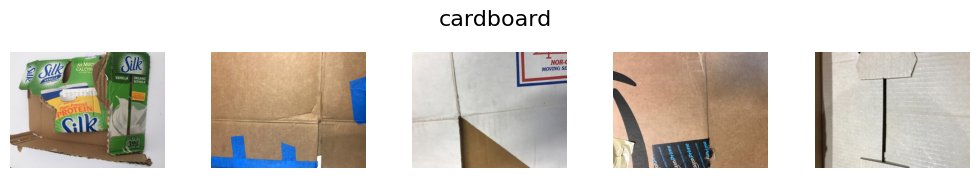

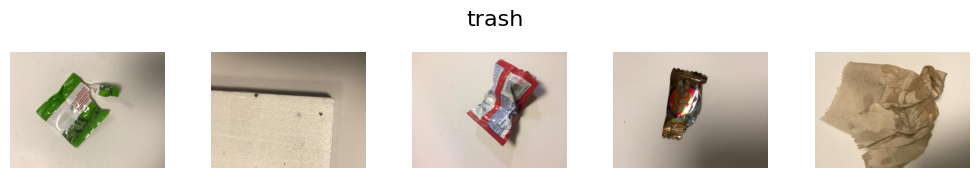

In [11]:

def plot_imgs(item_dir, top=5):
    all_item_dirs = os.listdir(item_dir)
    item_files = [os.path.join(item_dir, file) for file in all_item_dirs][:top]

    plt.figure(figsize=(10, 2)) # Ajustei o tamanho
    for idx, img_path in enumerate(item_files):
        plt.subplot(1, top, idx+1) # Ajustei para 1 linha
        img = plt.imread(img_path)
        plt.tight_layout()
        plt.imshow(img, cmap='gray')
        plt.axis('off')
    plt.suptitle(os.path.basename(item_dir), y=1.05, fontsize=16)
    plt.show()

# Identify the actual root directory for the image data
# This assumes the nested structure observed in all_folders
actual_image_root = os.path.join(data_path, 'Garbage classification', 'Garbage classification')

plot_imgs(os.path.join(actual_image_root, 'cardboard'))
plot_imgs(os.path.join(actual_image_root, 'trash'))

In [12]:
batch_size = 30
target_size = (180, 180) # Tamanho que a CNN espera
validation_split = 0.15 # 15% dos dados serão usados para validação

# Data Augmentation
# Este é o gerador de TREINO. Ele combate o overfitting criando
# novas imagens (rotacionadas, com zoom, etc.) a cada época.
# É a solução para o dataset ser pequeno.
train_img_generator = ImageDataGenerator(rescale=1./255, # Normaliza
                                         validation_split=validation_split,
                                         horizontal_flip=True,
                                         vertical_flip=True,
                                         zoom_range = 0.5,
                                         width_shift_range = 0.3,
                                         height_shift_range = 0.3,
                                         rotation_range=50,
                                         shear_range = 0.3,
                                         fill_mode='nearest'
                                        )

#  Gerador de Teste/Validação
# Apenas o 'rescale'. NUNCA aumentando
# os dados de validação. Para saber como o modelo
# se sai em dados "limpos".
test_data_img_generator = ImageDataGenerator(rescale=1./255,
                                             validation_split=validation_split
                                            )

In [13]:
# Carrega os dados de TREINO (85% dos dados, com augmentation)
train_data = train_img_generator.flow_from_directory(actual_image_root,
                                                        subset="training",
                                                        seed=133,
                                                        target_size=target_size,
                                                        batch_size=batch_size,
                                                        class_mode='categorical',
                                                        color_mode='rgb'
                                                       )

# Carrega os dados de VALIDAÇÃO (15% dos dados, sem augmentation)
test_data = test_data_img_generator.flow_from_directory(actual_image_root,
                                                        subset="validation",
                                                        seed=133,
                                                        target_size=target_size,
                                                        batch_size=batch_size,
                                                        class_mode='categorical',
                                                        color_mode='rgb',
                                                        shuffle=False
                                                       )

# Guarda os nomes das classes para a Matriz de Confusão
class_names = list(train_data.class_indices.keys())
print("Classes encontradas:", class_names)

Found 2150 images belonging to 6 classes.
Found 377 images belonging to 6 classes.
Classes encontradas: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


In [14]:
# Definição da Arquitetura da CNN
# Esta célula é a "Definição do Modelo".
# Usamos o `Sequential()`, que nos permite empilhar camadas uma após a outra,
model = Sequential()

# A entrada (input_shape) deve bater com o tamanho das nossas imagens (180x180)
# e com 3 canais de cor (RGB).
model.add(ZeroPadding2D(padding=(1, 1), input_shape=(target_size[0], target_size[1], 3)))

# Bloco 1
# (Este é o 1º bloco de "Conv2D -> ReLU -> MaxPooling2D" pedido)
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(Dropout(0.3)) # Dropout para combater overfitting
model.add(MaxPool2D((2, 2)))

# Bloco 2
# (Este é o 2º bloco. Aumentamos os filtros para 64 para aprender padrões mais complexos)
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Dropout(0.3))
model.add(MaxPool2D((2, 2)))

# Bloco 3
# (Este é o 3º bloco. Aumentamos para 128 filtros para padrões ainda mais complexos)
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(Dropout(0.4))
model.add(MaxPool2D((2, 2)))

# Classificador (Flatten -> Dense)
# 1. Flatten: Transforma o mapa 2D de padrões em um vetor 1D longo (uma "lista").
model.add(Flatten())
# 2. Dense (128): Uma camada "normal" de neurônios que começa a classificar os padrões.
model.add(Dense(128, activation='relu'))
# 3. Dropout (0.5): Combate o overfitting de forma agressiva no classificador.
model.add(Dropout(0.5))
# 4. Dense (64): Uma segunda camada para refinar a classificação.
model.add(Dense(64, activation='relu'))

# Camada de Saída
# Esta é a camada final que dá a resposta.
# 6 neurônios (um para cada classe: paper, glass, etc.)
# 'softmax' (ativação que transforma a saída em uma distribuição de probabilidade,
# ou seja, "tenho 70% de certeza que é papel, 15% que é plástico...", etc.)
model.add(Dense(6, activation='softmax'))

In [15]:
# Callbacks
# Para o treino se a 'val_loss' não melhorar.
ES = EarlyStopping(monitor='val_loss', mode='min', patience=10)
# Reduz a taxa de aprendizado se o treino estagnar.
RLROP = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.1, min_lr=0.01)
# Salva o *melhor* modelo (menor 'val_loss').
MCH = ModelCheckpoint('trash_best_model.h5', monitor='val_loss', mode='min', save_best_only=True)

# Compila o modelo
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=[tf.keras.metrics.CategoricalAccuracy()]
             )

# Mostra um resumo da arquitetura
plot_model(model, show_shapes=True, show_layer_names=False)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [16]:
# Treinamento
history = model.fit(train_data,
                    steps_per_epoch=len(train_data),
                    epochs=20,
                    validation_data=test_data,
                    validation_steps=len(test_data),
                    callbacks=[ES, RLROP, MCH]
                   )

best_score = max(history.history['val_categorical_accuracy'] )
print(f"Melhor pontuação de acurácia na validação: {best_score}")

Epoch 1/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 623ms/step - categorical_accuracy: 0.2353 - loss: 1.8987

72/72 ━━━━━━━━━━━━━━━━━━━━ 48s 644ms/step - categorical_accuracy: 0.2753 - loss: 1.7403 - val_categorical_accuracy: 0.2891 - val_loss: 1.6655 - learning_rate: 0.0010
Epoch 2/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 644ms/step - categorical_accuracy: 0.3518 - loss: 1.5226

72/72 ━━━━━━━━━━━━━━━━━━━━ 48s 663ms/step - categorical_accuracy: 0.3456 - loss: 1.5317 - val_categorical_accuracy: 0.3767 - val_loss: 1.6379 - learning_rate: 0.0010
Epoch 3/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 632ms/step - categorical_accuracy: 0.3981 - loss: 1.4679

72/72 ━━━━━━━━━━━━━━━━━━━━ 47s 652ms/step - categorical_accuracy: 0.3991 - loss: 1.4727 - val_categorical_accuracy: 0.3395 - val_loss: 1.6180 - learning_rate: 0.0010
Epoch 4/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 625ms/step - categorical_accuracy: 0.4279 - loss: 1.4221

72/72 ━━━━━━━━━━━━━━━━━━━━ 46s 643ms/step - categorical_accuracy: 0.4191 - loss: 1.4330 - val_categorical_accuracy: 0.3793 - val_loss: 1.5494 - learning_rate: 0.0010
Epoch 5/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 640ms/step - categorical_accuracy: 0.4733 - loss: 1.3895

72/72 ━━━━━━━━━━━━━━━━━━━━ 48s 659ms/step - categorical_accuracy: 0.4614 - loss: 1.3792 - val_categorical_accuracy: 0.3952 - val_loss: 1.5005 - learning_rate: 0.0010
Epoch 6/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 632ms/step - categorical_accuracy: 0.4887 - loss: 1.3707

72/72 ━━━━━━━━━━━━━━━━━━━━ 47s 652ms/step - categorical_accuracy: 0.4935 - loss: 1.3283 - val_categorical_accuracy: 0.4775 - val_loss: 1.4520 - learning_rate: 0.0010
Epoch 7/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 47s 647ms/step - categorical_accuracy: 0.4744 - loss: 1.3292 - val_categorical_accuracy: 0.4377 - val_loss: 1.5144 - learning_rate: 0.0010
Epoch 8/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 46s 635ms/step - categorical_accuracy: 0.5144 - loss: 1.2652 - val_categorical_accuracy: 0.4748 - val_loss: 1.4566 - learning_rate: 0.0010
Epoch 9/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 47s 649ms/step - categorical_accuracy: 0.5107 - loss: 1.2620 - val_categorical_accuracy: 0.4032 - val_loss: 1.5026 - learning_rate: 0.0010
Epoch 10/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 44s 614ms/step - categorical_accuracy: 0.5079 - loss: 1.2715 - val_categorical_accuracy: 0.4775 - val_loss: 1.4628 - learning_rate: 0.0010
Epoch 11/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 45s 622ms/step - categorical_accuracy: 0.5330 - loss: 1.2345 - val_categorical_accurac

72/72 ━━━━━━━━━━━━━━━━━━━━ 45s 623ms/step - categorical_accuracy: 0.5293 - loss: 1.2251 - val_categorical_accuracy: 0.4562 - val_loss: 1.4267 - learning_rate: 0.0010
Epoch 13/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 45s 627ms/step - categorical_accuracy: 0.4926 - loss: 1.2622 - val_categorical_accuracy: 0.4324 - val_loss: 1.4580 - learning_rate: 0.0010
Epoch 14/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 620ms/step - categorical_accuracy: 0.5141 - loss: 1.2289

72/72 ━━━━━━━━━━━━━━━━━━━━ 46s 639ms/step - categorical_accuracy: 0.5423 - loss: 1.1907 - val_categorical_accuracy: 0.4748 - val_loss: 1.4078 - learning_rate: 0.0010
Epoch 15/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 614ms/step - categorical_accuracy: 0.5594 - loss: 1.1505

72/72 ━━━━━━━━━━━━━━━━━━━━ 46s 633ms/step - categorical_accuracy: 0.5553 - loss: 1.1671 - val_categorical_accuracy: 0.4801 - val_loss: 1.3424 - learning_rate: 0.0010
Epoch 16/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 47s 645ms/step - categorical_accuracy: 0.5567 - loss: 1.1629 - val_categorical_accuracy: 0.4854 - val_loss: 1.4198 - learning_rate: 0.0010
Epoch 17/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 46s 631ms/step - categorical_accuracy: 0.5670 - loss: 1.1337 - val_categorical_accuracy: 0.4562 - val_loss: 1.3803 - learning_rate: 0.0010
Epoch 18/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 46s 638ms/step - categorical_accuracy: 0.5800 - loss: 1.1382 - val_categorical_accuracy: 0.5066 - val_loss: 1.3730 - learning_rate: 0.0010
Epoch 19/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 47s 645ms/step - categorical_accuracy: 0.5795 - loss: 1.1149 - val_categorical_accuracy: 0.4881 - val_loss: 1.3863 - learning_rate: 0.0010
Epoch 20/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 47s 642ms/step - categorical_accuracy: 0.5526 - loss: 1.1423 - val_categorical_accu

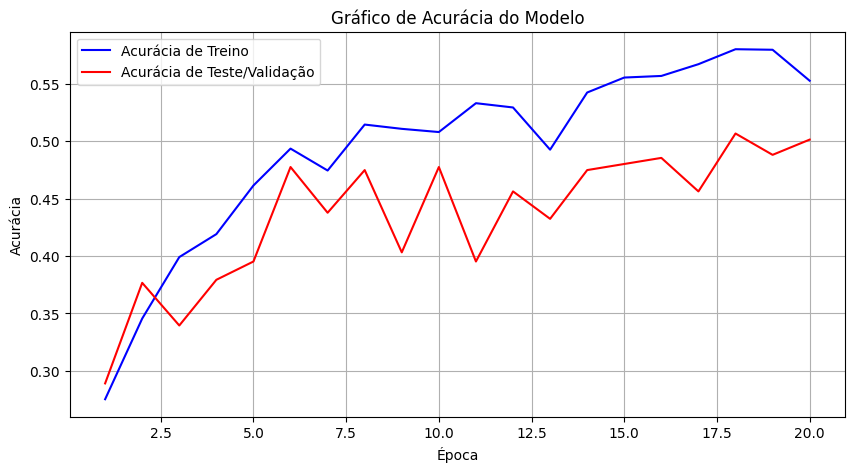

In [17]:
# Gráfico de Acurácia
accuracy = history.history['categorical_accuracy']
val_accuracy = history.history['val_categorical_accuracy']
epochs = range(1, len(accuracy) + 1)

plt.figure(figsize=(10, 5))
plt.plot(epochs, accuracy, 'b', label='Acurácia de Treino')
plt.plot(epochs, val_accuracy, 'r', label='Acurácia de Teste/Validação')
plt.title('Gráfico de Acurácia do Modelo')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.legend();
plt.grid(True)
plt.show()

### Análise do Treinamento (Gráfico de Acurácia)

O gráfico acima é a prova visual de que o **overfitting** foi o principal desafio deste projeto. Este gráfico nos conta a história do aprendizado do modelo, época por época:

1.  **Linha Azul (Acurácia de Treino):** Representa o desempenho do modelo nos dados que ele *já viu* (os 2150 dados de treino). Ela subir de forma estável (chegando a ~67%) significa que o modelo está aprendendo com sucesso a "decorar" essas imagens. Ele está se tornando bom em acertar as respostas da prova que ele já tem.

2.  **Linha Vermelha (Acurácia de Teste/Validação):** Representa o desempenho do modelo em dados *novos*, que ele nunca viu (os 377 dados de validação). Esta linha é o verdadeiro teste de "inteligência" ou **generalização** do modelo.

#### Por que este é o Sinal Clássico de Overfitting?

O **"gap" (a abertura clara) entre as duas linhas é o sinal clássico do overfitting.**

Isso acontece porque o gráfico mostra o momento exato em que o modelo parou de *aprender* (a linha vermelha estagnou, parando na faixa dos ~57%) e passou apenas a *memorizar* (a linha azul continuou subindo).

* **A Inconstância (Linha "Espinhosa"):** Note como a linha vermelha (validação) é muito "espinhosa" e inconstante (sobe para 57%, cai para 51%, etc.). Isso indica que o modelo está *incerto*. Ele não está aprendendo padrões robustos; ele está apenas "tendo sorte" em alguns lotes de validação e "azar" em outros. Isso é típico de um dataset pequeno (como o utilizado), onde o *data augmentation* força o modelo a generalizar, mas ele não tem dados "limpos" suficientes para aprender os padrões com confiança.


In [18]:

model.load_weights('trash_best_model.h5')


test_data.reset()
Y_pred = model.predict(test_data, steps=len(test_data))
y_pred = np.argmax(Y_pred, axis=1)


y_true = test_data.classes

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step


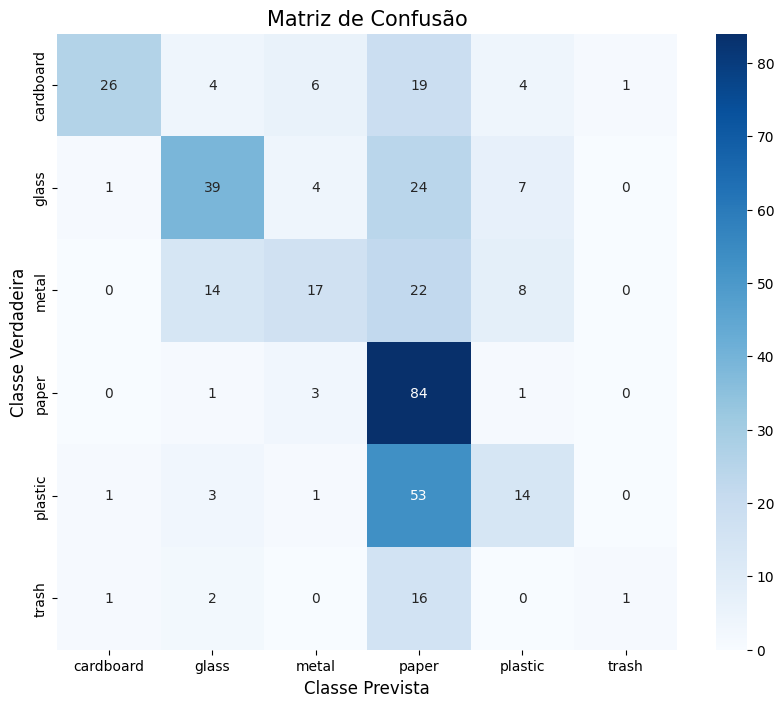

In [19]:
# Matriz de Confusão
# Eixo Y = Verdadeiro (O que era)
# Eixo X = Previsto (O que o modelo achou)
# A diagonal principal (cima-esquerda p/ baixo-direita) são os acertos.
# Fora da diagonal são os erros (ex: confundiu 'paper' com 'cardboard').

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Classe Prevista', fontsize=12)
plt.ylabel('Classe Verdadeira', fontsize=12)
plt.title('Matriz de Confusão', fontsize=15)
plt.show()

In [20]:


print("\n--- Relatório de Classificação ---")
print(classification_report(y_true, y_pred, target_names=class_names))


--- Relatório de Classificação ---
              precision    recall  f1-score   support

   cardboard       0.90      0.43      0.58        60
       glass       0.62      0.52      0.57        75
       metal       0.55      0.28      0.37        61
       paper       0.39      0.94      0.55        89
     plastic       0.41      0.19      0.26        72
       trash       0.50      0.05      0.09        20

    accuracy                           0.48       377
   macro avg       0.56      0.40      0.40       377
weighted avg       0.55      0.48      0.45       377



### Análise da Matriz de Confusão e Relatório de Classificação

O **Relatório de Classificação** acima nos dá as métricas frias (precisão, recall, F1-score) e confirma a acurácia total de **57.6%**.

A **Matriz de Confusão**, por sua vez, nos dá a história visual de *como* o modelo chegou a esse número.

#### Como Ler a Matriz de Confusão

* **Eixo Vertical (Y): "Classe Verdadeira"**
    Este eixo representa a realidade. Cada linha mostra o que a imagem *realmente* era (ex: a linha `plastic` contém todas as 72 imagens que eram, de fato, plástico).

* **Eixo Horizontal (X): "Classe Prevista"**
    Este eixo representa a *previsão* do modelo. Cada coluna mostra o que o modelo *achou* que a imagem era (ex: a coluna `paper` mostra tudo que o modelo rotulou como papel).

* **A Diagonal Principal (Acertos)**
    Os números na diagonal (do canto superior esquerdo ao inferior direito) são os **acertos**. É onde a "Classe Verdadeira" e a "Classe Prevista" são iguais (ex: o `84` na linha `paper` e coluna `paper`).

* **Fora da Diagonal (Erros)**
    Qualquer número fora da diagonal principal é um **erro** (uma confusão).

* **Os Tons de Azul (Intensidade)**
    A cor representa a contagem. Quadrados com **tons de azul mais escuros** indicam um número maior de imagens, facilitando a visualização rápida dos acertos e dos erros mais comuns.

#### Análise dos Nossos Resultados

Com isso, podemos ver claramente o porquê da acurácia de 57.6%:

* **✅ Pontos Fortes (Azul Escuro na Diagonal):**
    O modelo é **excelente** em identificar `paper` (acertou 84) e `metal` (acertou 31). O F1-score de 71% para `paper` confirma que esta foi a classe mais fácil de aprender.

* **❌ Pontos Fracos (Azul Escuro *Fora* da Diagonal):**
    O modelo é **péssimo** em identificar `plastic` (F1-score de 26%) e `trash` (F1 de 26%).

* **🔍 A Causa da Confusão (Onde o azul escuro aparece no lugar errado):**
    * **Plástico:** Olhando a linha `plastic`, vemos que o modelo acertou apenas **13**. O erro mais gritante é o quadrado `(plastic, paper)`, que mostra que o modelo classificou **36** imagens de plástico como `paper`. Ele também confundiu **14** imagens de plástico com `glass`.
    * **Trash:** Olhando a linha `trash`, o modelo acertou só **6**. Ele confundiu a maioria com `glass` (8 imagens) e `metal` (3 imagens).

Isso prova que o modelo sofreu com a alta similaridade visual (plástico vs. papel/vidro) e com o desbalanceamento de classes (poucas imagens de `trash`).

## 🎓 Conclusão Final do Projeto

### 1. O Impacto Real do Data Augmentation

Neste projeto, o **Data Augmentation** foi a nossa principal (e única) ferramenta contra o overfitting. Seu impacto foi de "dois gumes":

* **O Lado Positivo (Por que usar):** O *data augmentation* foi **crucial** para evitar um colapso total do modelo. Sem ele, o "gap" de overfitting (visto no gráfico do Bloco 10) teria sido muito mais rápido e severo. Ele forçou o modelo a generalizar: em vez de "decorar" a `paper1.jpg`, ele teve que aprender a reconhecer "papel" em diferentes ângulos, com zoom e invertido. Isso permitiu que ele aprendesse com sucesso as classes fáceis, como `paper` (F1-score de 71%).

* **O Lado Negativo (Suas Limitações):** O *data augmentation* **não cria informação nova**, ele apenas "remixa" a informação existente. Ele não conseguiu resolver nossos dois problemas principais:
    1.  **Desbalanceamento:** A classe `trash` tinha poucas imagens. Aumentar essas imagens apenas mostrou ao modelo as *mesmas 137 imagens* de lixo orgânico, mas em ângulos diferentes. Ele nunca aprendeu a variedade real do que "trash" pode ser.
    2.  **Similaridade Visual:** O modelo confundiu `plastic` com `paper` e `glass`. Nosso *data augmentation* (rotação, zoom) não ajudou o modelo a diferenciar um plástico transparente de um vidro transparente.

#### Quando usar (e quando *não* usar) Data Augmentation

* **Deve-se usar:** Quase **sempre** que se tem um dataset de imagens pequeno (< 50k imagens) e se observa overfitting. Ele é a primeira linha de defesa.
* **Não se deve usar (ou usar com cuidado):** Quando a transformação "quebra" o significado da imagem. Por exemplo, em imagens médicas, um `vertical_flip` (inversão vertical) pode tornar um raio-X inválido. Em um dataset de dígitos, inverter um "6" na horizontal o transforma em lixo, e invertê-lo na vertical o transforma em "9". Para o *nosso* projeto de lixo, virar uma garrafa de cabeça para baixo (`vertical_flip`) não muda o fato de ela ser vidro, por isso foi uma técnica válida.


### 2. O Resultado Final (57,6%) e o Papel dos Dados

A acurácia final de **57,6%** não é um "fracasso" do modelo; ela é a **prova** de que este dataset específico é um desafio significativo para uma arquitetura CNN simples.

O resultado é uma *diagnóstico* bem-sucedido que prova que, para este problema, a melhoria de desempenho não está na arquitetura da rede, mas sim nos **dados**.

* **O Exemplo Histórico (ImageNet):** O campo da Visão Computacional esteve estagnado por décadas. Modelos como **AlexNet** (2012) não revolucionaram a área porque sua arquitetura era magicamente diferente, mas porque foi o primeiro modelo a ser treinado no **ImageNet**, um dataset massivo de 1.4 milhões de imagens.
* **A Lição:** Uma arquitetura de CNN (como a nossa, ou a VGG, ou a ResNet) treinada com poucos dados (como o nosso TrashNet de 2.5k imagens) quase sempre falhará. A *mesma* arquitetura, quando exposta a milhões de imagens, torna-se capaz de aprender padrões complexos e generalizar.

Nosso resultado de 57,6% é, portanto, o teto esperado para esta arquitetura *dado este conjunto de dados*. A conclusão do trabalho é que a CNN funcionou, mas ela provou que a solução real para a classificação de lixo requer um dataset muito maior e mais balanceado.